In [1]:
# !pip install pydantic
# !pip install typing

In [53]:
import pandas as pd
import pickle
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random, vmap
import numpy as  np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import torch

from pydantic import BaseModel
from pydantic import validator
from typing import List
from typing import Union
from math import factorial

Classes used for defining a spin system. Allows for easy handling of couplings

In [54]:
class SimpleCoupling(BaseModel):
    '''
    site_index: list of the indicies of the site objects which are coupled
    isotropic_j: j-coupling frequency in Hz
    '''
    site_index: List[int]
    isotropic_j: float = 0.0
    
    @validator("site_index", always=True)
    def validate_site_index(cls, v, *, values, **kwargs):
        if len(v) != 2:
            raise ValueError("Site index must a list of two integers.")
        if v[0] == v[1]:
            raise ValueError("The two site indexes must be unique integers.")
        return v
    
class SimpleSite(BaseModel):
    '''
    isotope: specific isotope for NMR active atom
    isotropic_chemical_shift: value in ppm for chemical shift. Converted to a list when coupled
    multiplicity: Number of atoms responsible for this signal. Irrep in spin system
    intensity: the relative signal intensity. Taken to be multiplicity but updated upon coupling
    couple_flag: flag to determine if site has been coupled before. Necessary for use with JAX
    '''
    
    isotope: str = "1H"
    isotropic_chemical_shift: Union[float, List] = 0.0
    multiplicity: int = 1
    intensity: int = 1
    couple_flag: bool = False
    symmetry_multiplier: int = 1
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.intensity = self.multiplicity
        if isinstance(self.isotropic_chemical_shift, float):
            self.isotropic_chemical_shift = jnp.array([self.isotropic_chemical_shift])
        if isinstance(self.intensity, int):
            self.intensity = [self.intensity]
            
    def set_flag(self, state):
        self.couple_flag = state
        
    def set_intensity(self, intensity):
        self.intensity = intensity
        
    def set_isotropic_chemical_shift(self, isotropic_chemical_shift):
        self.isotropic_chemical_shift = isotropic_chemical_shift
    
class SimpleSpinSystem(BaseModel):
    '''
    collection of sites and their couplings
    '''
    sites: List[SimpleSite] = []
    couplings: List[SimpleCoupling] = []

In [55]:
def comb(n,k):
    return factorial(n) / factorial(k) / factorial(n-k)

def comb_all(n):
    '''
    creates the combinatorial intensities expected for a coupled site with n neighbors
    '''
    combs = [comb(n, i) for i in range(n+1)]
    return combs/np.sum(combs)
        

def ppm_to_Hz(ppm_val, carrier_frequency= 500):
    '''
    Converts a j-coupling frequency in ppm back to MHz
    carrier_frequency in Hz
    '''
    return ppm_val*(carrier_frequency * 1000000)/1e6

def Hz_to_ppm(Hz_val, carrier_frequency = 500):
    '''
    Converts a j-coupling frequency in Hz back to ppm
    carrier_frequency in MHz
    '''
    return (Hz_val*1e6)/(carrier_frequency*1000000)


def couple_SimpleSpinSystem(SimpleSpinSystem, carrier_frequency = 500):
    '''
    Function to update isotropic_chemical_shift values in a site object to the list of shifts
    expected in a coupled spin system
    '''
    if len(SimpleSpinSystem.couplings) == 0:
        return
    else:
        for coupling in SimpleSpinSystem.couplings:
            coupled_pair = coupling.site_index
            isotropic_j_ppm = Hz_to_ppm(coupling.isotropic_j, carrier_frequency)

            for i in coupled_pair:
                j = [s for s in coupled_pair if s != i][0]

                delta = SimpleSpinSystem.sites[i].isotropic_chemical_shift
                base_intensity = SimpleSpinSystem.sites[i].intensity

                neighbor_count = SimpleSpinSystem.sites[j].multiplicity * SimpleSpinSystem.sites[j].symmetry_multiplier
                centered_list = [i - (neighbor_count-1)/2 for i in range(neighbor_count + 1)]
                
                if SimpleSpinSystem.sites[i].couple_flag == False:
                    updated_freqs = [delta + n*isotropic_j_ppm for n in centered_list]
                    SimpleSpinSystem.sites[i].set_flag(state = True)
                else: 
                    updated_freqs = [d + n*isotropic_j_ppm for d in delta for n in centered_list]
                updated_intensities = [base*i for base in base_intensity for i in comb_all(neighbor_count)]

                SimpleSpinSystem.sites[i].set_isotropic_chemical_shift(updated_freqs)
                SimpleSpinSystem.sites[i].set_intensity(updated_intensities)
            
def parse_coupled_SimpleSpinSystem(SimpleSpinSystem):
    '''
    Systematically parses a spin system to obtain the frequencies of each signal and the associated signal instensity
    '''
    shifts = jnp.array([])
    couplings = []
    for site in SimpleSpinSystem.sites:
        shifts = jax.numpy.append(shifts, jnp.array(site.isotropic_chemical_shift))
        couplings += site.intensity
        
    return jnp.array(shifts), jnp.array(couplings)

In [56]:
def render_spect(spin_system, shifts, eval_points, render_width):
    """
    Shifts: locations of shifts (length N)
    intenisty: intensity of shifts (reflecting duplicate shift values, like in a methyl group)
    eval_points: evaluation points
    render_width: peak width
    
    
    return: length(eval_points) observation 
    """
    sites_count = len(spin_system.sites)
    temp_spin_system = spin_system.copy(deep = True)
    
    for i in range(sites_count):
        temp_spin_system.sites[i].isotropic_chemical_shift = shifts[i]
    couple_SimpleSpinSystem(temp_spin_system)
    updated_shifts, updated_intenisities = parse_coupled_SimpleSpinSystem(temp_spin_system)
    
    y = jnp.exp(-(updated_shifts[:, jnp.newaxis]- eval_points)**2/render_width**2)

    y_sum = (y * updated_intenisities[:, jnp.newaxis]).sum(axis=0)
    
    return y_sum/y_sum.max()

def model(pred_shifts_mu, pred_shifts_sigma, spin_system, eval_points, y, high = None, low = None):

    MIXTURE_COMPONENTS, NUM_POSSIBLE_SHIFTS = pred_shifts_mu.shape
    EVAL_N = eval_points.shape[0]
    assert len(y) == len(eval_points)

    
    mixture_weights = numpyro.sample("mixture_weights",
                                     dist.HalfCauchy(scale=1 * jnp.ones(MIXTURE_COMPONENTS)))

    shifts = numpyro.sample("shifts", dist.TruncatedDistribution(dist.Normal(pred_shifts_mu, pred_shifts_sigma), low=low, high=high))

    A = [render_spect(sim, shift, x, RENDER_WIDTH) for sim, shift in zip(spin_system, shifts)]
    A = jnp.array(A)
    
    mu = A.T @ mixture_weights
    
    return numpyro.sample("obs", dist.Normal(mu, 0.1), obs=y)

# Borylation experimental data

/tmp/ipykernel_5000/1610951471.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df = df[df['x'].between(6.5, 9.3, inclusive=True)]


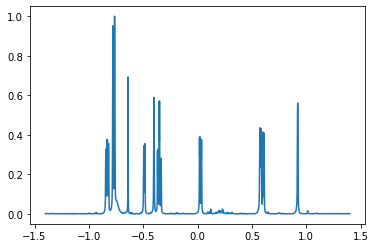

In [57]:
df=pd.read_csv('data/arene.csv', sep='\t',header=None, names=["x", "y", "none"])
df.head()


df = df[df['x'].between(6.5, 9.3, inclusive=True)]

avg = (9.3 + 6.5)/2
x = df['x'].to_numpy() - avg


y = df['y'].to_numpy()
y = y/y.max()
plt.plot(x, y)

In [58]:
# !pip install csdmpy
# !pip install mrsimulator

In [59]:
from mrsimulator import Simulator, SpinSystem, Site, Coupling
from mrsimulator.methods import BlochDecaySpectrum

import csdmpy as cp
from collections import defaultdict
from mrsimulator import signal_processing as sp

1.399709999999999 -1.39973


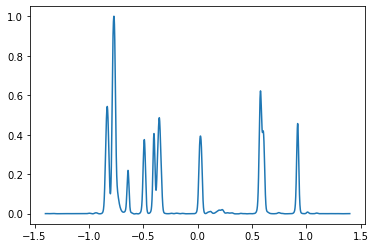

In [60]:
processor = sp.SignalProcessor(
    operations=[
        sp.IFFT(), sp.apodization.Gaussian(FWHM='10 Hz'), sp.FFT()# 10 hz
    ]
)

carrier_freq = '500'
coord_offset = x[0]*float(carrier_freq)
count = len(x)
increment = int((x[-1]-x[0])*float(carrier_freq))/count

dim = cp.LinearDimension(count=count, increment=f"{increment} Hz", label="frequency", description="Hz", coordinates_offset = f'-{coord_offset} Hz')

csdm_object = cp.CSDM(
    dependent_variables=[cp.as_dependent_variable(y)],
    dimensions=[dim]
)

processed_data = processor.apply_operations(data=csdm_object).real
y = processed_data.dependent_variables[0].components[0]
y = y/y.max()

plt.plot(x,y)

In [61]:
mixture_weights_true = jnp.array([1, 0, 1.32, 0.55, 0, 0])

shifts_true = jnp.array([
    [8.48, 7.06, 7.49, 7.15],
    [8.43, 7.07, 8.09, 0],
    [8.51, 7.47, 7.56, 0],
    [8.85, 7.94, 7.13, 0],
    [7.45, 7.71, 7.12, 0],
    [8.39, 7.00, 7.46, 7.12]
])

intensities = jnp.ones_like(shifts_true)

shifts_true = shifts_true - avg

shifts_pred_sigma = jnp.ones_like(shifts_true) * 0.1 

# Creating the Set of Potential Molecules

In [62]:
###########################################################################
## SM
###########################################################################
sm_h2 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[0][0], multiplicity = 1)
sm_h3 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[0][1], multiplicity = 1)
sm_h4 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[0][2], multiplicity = 1)
sm_h5 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[0][3], multiplicity = 1)
sm_sites = [sm_h2, sm_h3, sm_h4, sm_h5]

sm_c_1 = SimpleCoupling(site_index=[0, 1], isotropic_j=5.8)
sm_c_2 = SimpleCoupling(site_index=[0, 2], isotropic_j=1.9)
sm_c_3 = SimpleCoupling(site_index=[1, 2], isotropic_j=9)
sm_c_4 = SimpleCoupling(site_index=[1, 3], isotropic_j=1.1)
sm_c_5 = SimpleCoupling(site_index=[2, 3], isotropic_j=9.1)
sm_couplings = [sm_c_1, sm_c_2, sm_c_3, sm_c_4, sm_c_5]

sm = SimpleSpinSystem(sites=sm_sites, couplings=sm_couplings)

###########################################################################
## C3
###########################################################################
c3_h2 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[1][0], multiplicity = 1)
c3_h3 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[1][1], multiplicity = 1)
c3_h4 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[1][2], multiplicity = 1)
c3_sites = [c3_h2, c3_h3, c3_h4,]

c3_c_1 = SimpleCoupling(site_index=[0, 1], isotropic_j=5.9)
c3_c_2 = SimpleCoupling(site_index=[0, 2], isotropic_j=2.1)
c3_c_3 = SimpleCoupling(site_index=[1, 2], isotropic_j=8.8)
c3_couplings = [c3_c_1, c3_c_2, c3_c_3]

c3 = SimpleSpinSystem(sites=c3_sites, couplings=c3_couplings)

###########################################################################
## C4
###########################################################################
c4_h2 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[2][0], multiplicity = 1)
c4_h3 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[2][1], multiplicity = 1)
c4_h4 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[2][2], multiplicity = 1)
c4_sites = [c4_h2, c4_h3, c4_h4]

c4_c_1 = SimpleCoupling(site_index=[0, 1], isotropic_j=5.7)
c4_c_2 = SimpleCoupling(site_index=[0, 2], isotropic_j=1)
c4_couplings = [c4_c_1, c4_c_2]

c4 = SimpleSpinSystem(sites=c4_sites, couplings=c4_couplings)

###########################################################################
## C5
###########################################################################
c5_h2 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[3][0], multiplicity = 1)
c5_h3 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[3][1], multiplicity = 1)
c5_h4 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[3][2], multiplicity = 1)
c5_sites = [c5_h2, c5_h3, c5_h4,]

c5_c_1 = SimpleCoupling(site_index=[0, 1], isotropic_j=1.8)
c5_c_2 = SimpleCoupling(site_index=[1, 2], isotropic_j=9.0)
c5_couplings = [c5_c_1, c5_c_2]

c5 = SimpleSpinSystem(sites=c5_sites, couplings=c5_couplings)

###########################################################################
## C6
###########################################################################
c6_h2 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[4][0], multiplicity = 1)
c6_h3 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[4][1], multiplicity = 1)
c6_h4 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[4][2], multiplicity = 1)
c6_sites = [c6_h2, c6_h3, c6_h4]

c6_c_1 = SimpleCoupling(site_index=[0, 1], isotropic_j=8.9)
c6_c_2 = SimpleCoupling(site_index=[0, 2], isotropic_j=1.2)
c6_c_3 = SimpleCoupling(site_index=[1, 2], isotropic_j=9.1)
c6_couplings = [c6_c_1, c6_c_2, c6_c_3]

c6 = SimpleSpinSystem(sites=c6_sites, couplings=c6_couplings)

###########################################################################
## C7
###########################################################################
c7_h2 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[5][0], multiplicity = 1)
c7_h3 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[5][1], multiplicity = 1)
c7_h4 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[5][2], multiplicity = 1)
c7_h5 = SimpleSite(isotope='1H', isotropic_chemical_shift=shifts_true[5][3], multiplicity = 1)
c7_sites = [c7_h2, c7_h3, c7_h4, c7_h5]

c7_c_1 = SimpleCoupling(site_index=[0, 1], isotropic_j=5.8)
c7_c_2 = SimpleCoupling(site_index=[0, 2], isotropic_j=1.9)
c7_c_3 = SimpleCoupling(site_index=[1, 2], isotropic_j=8.9)
c7_c_4 = SimpleCoupling(site_index=[1, 3], isotropic_j=1.1)
c7_c_5 = SimpleCoupling(site_index=[2, 3], isotropic_j=9.1)
c7_couplings = [c7_c_1, c7_c_2, c7_c_3, c7_c_4, c7_c_5]

c7 = SimpleSpinSystem(sites=c7_sites, couplings=c7_couplings)

sim_objects = [sm, c3, c4, c5, c6, c7]

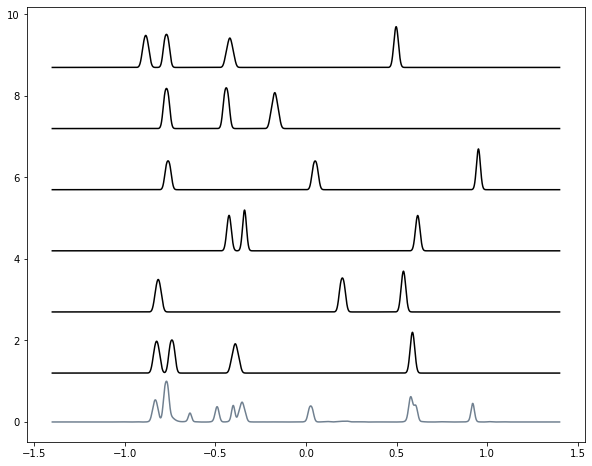

In [63]:
RENDER_WIDTH = 0.015

MIXTURE_COMPONENTS_N = len(sim_objects)

true_spect = np.zeros((MIXTURE_COMPONENTS_N, len(x)))

for i in range(MIXTURE_COMPONENTS_N):
    true_spect[i] = render_spect(sim_objects[i], shifts_true[i], x, RENDER_WIDTH)
    
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)
for i in range(MIXTURE_COMPONENTS_N):

    ax.plot(x, 
            true_spect[i]/true_spect[i].max() + 1.5*i + 1.2, c='k')
ax.plot(x, y, c = 'slategray')

In [64]:
num_samples = 3000
num_warmup = 1000

rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)


nuts_kernel = NUTS(model)

mcmc = MCMC(
    nuts_kernel,
    num_samples=num_samples,
    num_warmup = num_warmup
)

mcmc.run(rng_key_,
         pred_shifts_mu = shifts_true,
         pred_shifts_sigma = shifts_pred_sigma, 
         spin_system = sim_objects,
         eval_points = x,
         y=y,
        low = shifts_true - shifts_pred_sigma,
        high = shifts_true + shifts_pred_sigma)

sample: 100%|██████████| 4000/4000 [11:15<00:00,  5.93it/s, 31 steps of size 8.35e-02. acc. prob=0.89]   


In [65]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
mixture_weights[0]      0.62      0.01      0.63      0.61      0.64     25.85      1.02
mixture_weights[1]      0.03      0.01      0.03      0.02      0.05     56.13      1.00
mixture_weights[2]      0.35      0.01      0.35      0.33      0.37     18.63      1.04
mixture_weights[3]      0.49      0.01      0.49      0.48      0.51    441.27      1.01
mixture_weights[4]      0.03      0.01      0.03      0.02      0.05     17.21      1.11
mixture_weights[5]      0.02      0.01      0.02      0.00      0.04     72.72      1.01
       shifts[0,0]      0.57      0.00      0.57      0.57      0.57     23.92      1.01
       shifts[0,1]     -0.85      0.00     -0.85     -0.85     -0.85   3368.88      1.00
       shifts[0,2]     -0.37      0.00     -0.37     -0.37     -0.37   2577.23      1.00
       shifts[0,3]     -0.78      0.00     -0.78     -0.78     -0.78   1928.64      1.00
       shifts[1,0]  

In [67]:
from statistics import geometric_mean
def concentrations(sim_objects, shifts, intensities, x, RENDER_WIDTH):
    mult_list = []
    for sim in sim_objects:
        mult = 0
        for j in sim.sites:
            mult+=j.multiplicity
        mult_list.append(mult)
    conc = []
    for shift, intensity in zip(shifts, intensities):
        integral = [sum(render_spect(sim_objects[i], shift[i], x, RENDER_WIDTH)*intensity[i])/mult_list[i] for i in range(len(intensity))]
        normed = [i/sum(integral) for i in integral]
        conc.append(normed)
    return conc

In [68]:
est_shifts = mcmc.get_samples()['shifts']
est_mixture_weights = mcmc.get_samples()['mixture_weights']

concs_run_1 = concentrations(sim_objects, est_shifts, est_mixture_weights, x, RENDER_WIDTH)

true_concs = [0.45, 0, 0.25, 0.30, 0, 0]
for i in range(len(concs_run_1[0])):
    mol = [sublist[i] for sublist in concs_run_1]
    print(f'Molecule {i}: ', geometric_mean(mol), f' True: {true_concs[i]}')

Molecule 0:  0.4320097512269921  True: 0.45
Molecule 1:  0.02263060051270625  True: 0
Molecule 2:  0.20950511189638316  True: 0.25
Molecule 3:  0.29331520421035273  True: 0.3
Molecule 4:  0.027119306998638078  True: 0
Molecule 5:  0.00889358520662487  True: 0


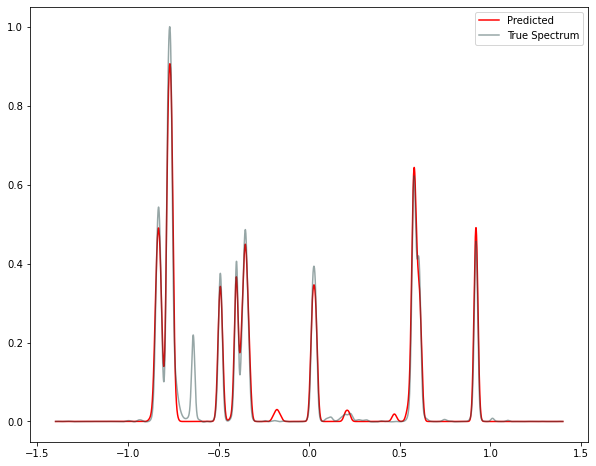

In [70]:
est_shifts = np.average(mcmc.get_samples()['shifts'], axis = 0)
est_conc = np.average(est_mixture_weights, axis = 0)

est_spect = np.zeros((MIXTURE_COMPONENTS_N, len(x)))

for i in range(MIXTURE_COMPONENTS_N):
    est_spect[i] = render_spect(sim_objects[i], est_shifts[i], x, RENDER_WIDTH)
    
est_spect = (est_spect.T @ est_conc)
    
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(x, est_spect, c='red', label = 'Predicted', zorder = 0)
ax.plot(x, y, c = 'darkslategray', label = 'True Spectrum', alpha = 0.5)

plt.legend()

Next we cut out anything under 10% and rerun.

In [65]:
est_shifts = np.average(mcmc.get_samples()['shifts'], axis = 0)
est_error = np.std(mcmc.get_samples()['shifts'], axis = 0)
sim_objects = [sm, c4, c5]

mixture_weights_true = jnp.array([1, 1.32, 0.55])

shifts_true = jnp.array([
    est_shifts[0],
    est_shifts[2], 
    est_shifts[3],
])

shifts_pred_sigma = jnp.array([
    est_error[0],
    est_error[2], 
    est_error[3], 
])


mcmc.run(rng_key_,
         pred_shifts_mu = shifts_true,
         pred_shifts_sigma = shifts_pred_sigma, 
         spin_system = sim_objects,
         eval_points = x,
         y=y,
        low = shifts_true - shifts_pred_sigma,
        high = shifts_true + shifts_pred_sigma)

sample: 100%|██████████| 4000/4000 [01:37<00:00, 41.05it/s, 7 steps of size 4.68e-01. acc. prob=0.92]  


In [69]:
est_shifts = mcmc.get_samples()['shifts']
est_mixture_weights = mcmc.get_samples()['mixture_weights']
concs_run_2 = concentrations(sim_objects, est_shifts, est_mixture_weights, x, RENDER_WIDTH)

true_concs = [0.45, 0.25, 0.30]
for i in range(len(concs_run_2[0])):
    mol = [sublist[i] for sublist in concs_run_2]
    print(f'Molecule {i}: ', geometric_mean(mol), f' True: {true_concs[i]}')

Molecule 0:  0.45577573240462255  True: 0.45
Molecule 1:  0.23690255739181024  True: 0.25
Molecule 2:  0.30723221286455743  True: 0.3


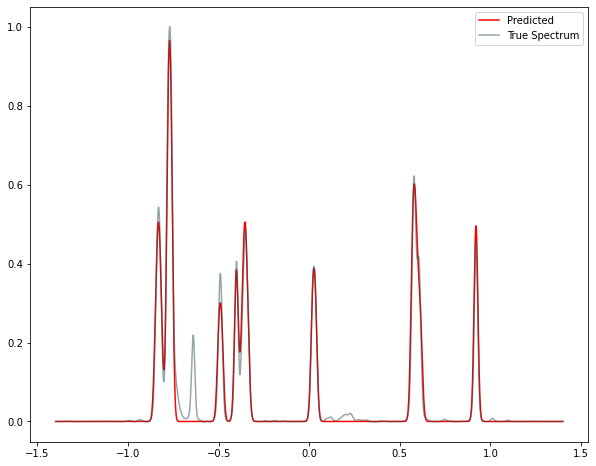

In [70]:
est_shifts = np.average(mcmc.get_samples()['shifts'], axis = 0)
est_conc = np.average(est_mixture_weights, axis = 0)

est_spect = np.zeros((3, len(x)))

for i in range(3):
    est_spect[i] = render_spect(sim_objects[i], est_shifts[i], x, RENDER_WIDTH)
    
est_spect = (est_spect.T @ est_conc)
    
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(x, est_spect, c='red', label = 'Predicted', zorder = 0)
ax.plot(x, y, c = 'darkslategray', label = 'True Spectrum', alpha = 0.5)
# plt.xlim([1.5,-1.5])
plt.legend()